In [37]:
# Set dataset path
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
import os
import glob


In [ ]:
# Root project folder
ROOT = r"d:/ImageForgeryDetection/Data"

# Paths
train_images_dir = os.path.join(ROOT, "train_images")
authentic_dir   = os.path.join(train_images_dir, "authentic")
forged_dir      = os.path.join(train_images_dir, "forged")
mask_dir        = os.path.join(ROOT, "train_masks")
test_dir        = os.path.join(ROOT, "test_images")

# Collect files
authentic_images = sorted(glob.glob(os.path.join(authentic_dir, "*.png")))
forged_images    = sorted(glob.glob(os.path.join(forged_dir, "*.png")))
mask_files       = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))
test_images      = sorted(glob.glob(os.path.join(test_dir, "*.png")))

# Print counts
print(f"Authentic images: {len(authentic_images)}")
print(f"Forged images: {len(forged_images)}")
print(f"Mask files: {len(mask_files)}")
print(f"Test images: {len(test_images)}")


Authentic images: 2377
Forged images: 2751
Mask files: 2751
Test images: 1


In [ ]:
# Image sample shapes and modes

from PIL import Image

for i in range(5):
    sample_image = Image.open(authentic_images[i])
    print("Sample authentic image shape:", sample_image.size, "Mode:", sample_image.mode)
    sample_image = Image.open(forged_images[i])
    print("Sample forged image shape:", sample_image.size, "Mode:", sample_image.mode)

Sample authentic image shape: (648, 512) Mode: RGB
Sample forged image shape: (648, 512) Mode: RGB
Sample authentic image shape: (1600, 1200) Mode: RGB
Sample forged image shape: (1600, 1200) Mode: RGB
Sample authentic image shape: (320, 256) Mode: RGBA
Sample forged image shape: (320, 256) Mode: RGBA
Sample authentic image shape: (1000, 666) Mode: RGB
Sample forged image shape: (1000, 666) Mode: RGB
Sample authentic image shape: (414, 712) Mode: RGBA
Sample forged image shape: (414, 712) Mode: RGB


In [38]:
# Check mask alignment for forged images
mask = np.load(mask_files[0])
print(mask.shape, np.unique(mask))


(1, 512, 648) [0 1]


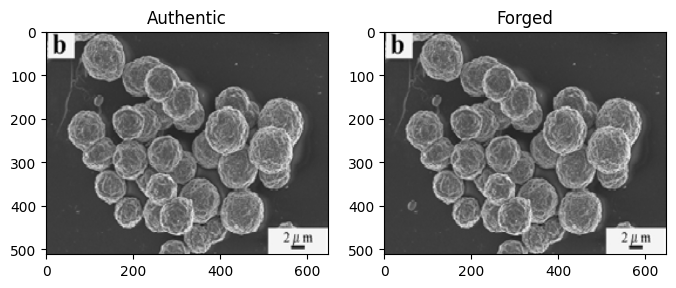

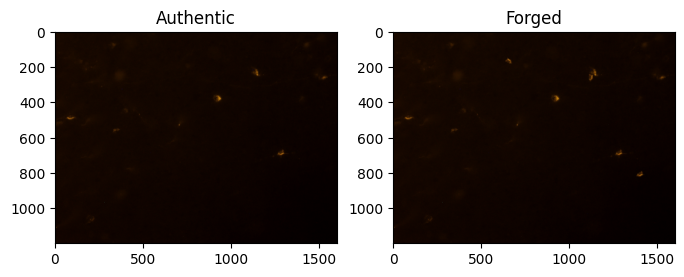

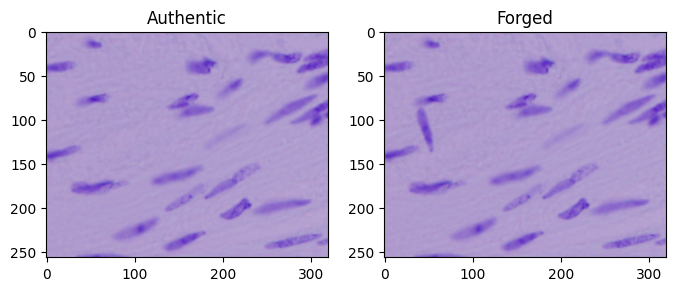

In [30]:
# Inspect forged vs authentic difference

import matplotlib.pyplot as plt

for i in range(3):
    forged = Image.open(forged_images[i]).convert("RGB")
    authentic = Image.open(authentic_images[i]).convert("RGB")
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(authentic)
    ax[0].set_title("Authentic")
    ax[1].imshow(forged)
    ax[1].set_title("Forged")
    plt.show()


In [39]:
# Helper function to load and preprocess an image
#ensures all images are:Converted to RGB(same format),Resized to 512×512, Normalized to [0,1] for visualization

def load_and_preprocess_image(img_path, size=(512, 512)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(size)
    return np.array(img) / 255.0


In [ ]:
#Function to load and resize a mask

def load_and_preprocess_mask(mask_path, size=(512, 512)):
    mask = np.load(mask_path, allow_pickle=True)

    # --- Handle different shapes ---
    if mask.ndim == 3:
        # Sometimes masks are (num_masks, H, W)
        # Combine all into one binary mask
        mask = np.sum(mask, axis=0)
    elif mask.ndim == 1 or mask.ndim == 0:
        # Some npy files contain a list of masks or empty arrays
        mask = np.zeros((512, 512))
    elif mask.ndim > 3:
        # Flatten anything extra
        mask = mask.squeeze()

    # Normalize to binary (0 or 1)
    mask = (mask > 0).astype(np.uint8)

    # Resize to target size
    mask_img = Image.fromarray(mask * 255)
    mask_img = mask_img.resize(size, resample=Image.NEAREST)
    return np.array(mask_img) / 255.0


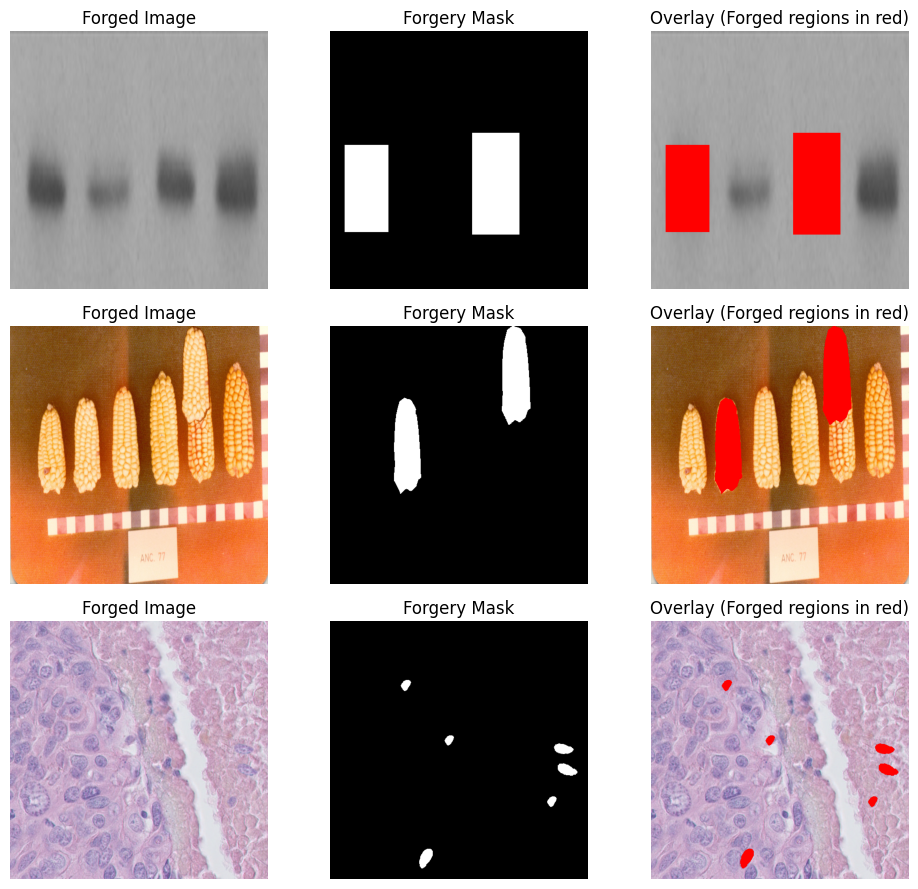

In [41]:
#Visualize random forged samples with their masks
import random

def visualize_samples(n=3):
    plt.figure(figsize=(10, n * 3))

    for i in range(n):
        idx = random.randint(0, len(forged_images) - 1)
        img_path = forged_images[idx]
        mask_path = mask_files[idx] if idx < len(mask_files) else None

        img = load_and_preprocess_image(img_path)
        mask = load_and_preprocess_mask(mask_path) if mask_path else np.zeros((512, 512))

        # Create overlay
        overlay = img.copy()
        overlay[mask > 0.5] = [1, 0, 0]  # Red overlay where forgery exists

        # Plot
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(img)
        plt.title("Forged Image")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Forgery Mask")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(overlay)
        plt.title("Overlay (Forged regions in red)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_samples(3)


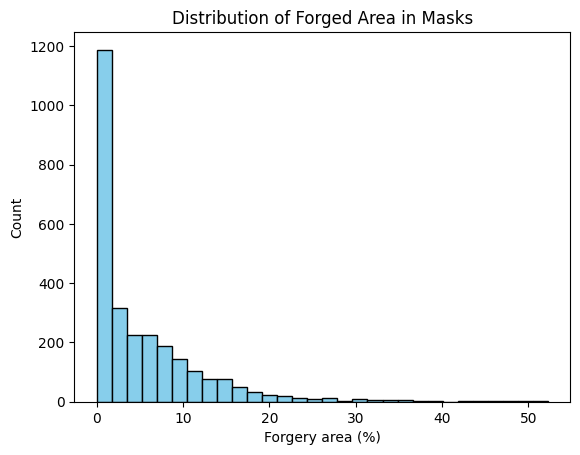

In [42]:
# Forgery Area Distribution (mask coverage %)

import matplotlib.pyplot as plt

mask_areas = []
for mask_path in mask_files:
    mask = np.load(mask_path, allow_pickle=True)
    if mask.ndim == 3:
        mask = np.sum(mask, axis=0)
    mask = (mask > 0).astype(np.uint8)
    mask_areas.append(mask.mean() * 100)  # % of pixels forged

plt.hist(mask_areas, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Forgery area (%)")
plt.ylabel("Count")
plt.title("Distribution of Forged Area in Masks")
plt.show()


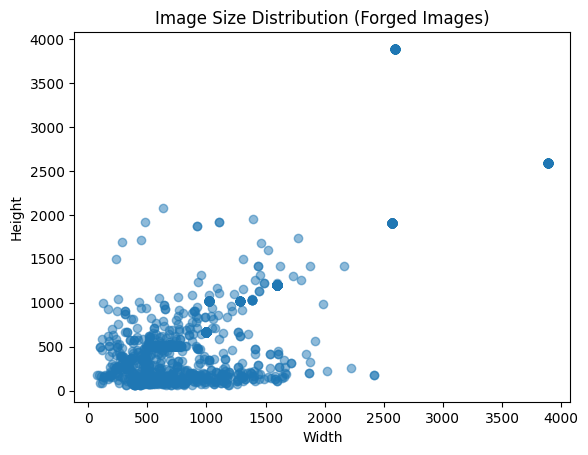

Unique sizes found: 763


In [43]:
# Image Size Distribution (forged images)

sizes = []
for path in forged_images:
    with Image.open(path) as img:
        sizes.append(img.size)

w, h = zip(*sizes)
plt.scatter(w, h, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution (Forged Images)")
plt.show()

unique_sizes = set(sizes)
print(f"Unique sizes found: {len(unique_sizes)}")
